In [1]:
import os
import skimage 
import numpy as np
from tqdm import tqdm
from tqdm.contrib import itertools as it
from pylibCZIrw import czi as pyczi


import matplotlib.pyplot as plt
# from scroutines.config_plots import *

/home/qlyu/mambaforge/envs/czi2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
f_r3v1 = '/scr/qlyu/projects/v1/multifish/trial_FX/inputs/LHA3_R3_tiny_V01.czi' 
f_r3v2 = '/scr/qlyu/projects/v1/multifish/trial_FX/inputs/LHA3_R3_tiny_V02.czi' 
f_r5v1 = '/scr/qlyu/projects/v1/multifish/trial_FX/inputs/LHA3_R5_tiny_V01.czi' 
f_r5v2 = '/scr/qlyu/projects/v1/multifish/trial_FX/inputs/LHA3_R5_tiny_V02.czi' 

f_r3m  = '/scr/qlyu/projects/v1/multifish/trial_FX/inputs/LHA3_R3_tiny.mvl' 
f_r5m  = '/scr/qlyu/projects/v1/multifish/trial_FX/inputs/LHA3_R5_tiny.mvl' 


In [3]:
outdir = '/scr/qlyu/projects/v1/multifish/trial_FX/inputs' 

In [4]:
f_r3v1_out1 = f_r3v1.replace('.czi', '_p1.czi') 

In [5]:
# !cat $f_r3m

In [6]:
# img.shape
# imgsub = img[:,:,:,:,:,:,:,:int(920/2),:int(660/2),:]
# imgsub.shape

In [7]:
# # define the filename
# # open the CZI for reading using a context manager (preferred way to do it)
with pyczi.open_czi(f_r3v1) as czidoc:
    meta = czidoc.metadata
    bbox = czidoc.total_bounding_box
    brec = czidoc.total_bounding_rectangle
    srec = czidoc.scenes_bounding_rectangle
    pxlt = czidoc.pixel_types
    # print(meta)
    

In [8]:
# meta
print(bbox)
print(brec)
print(srec)
print(pxlt)

{'T': (0, 1), 'Z': (0, 151), 'C': (0, 2), 'R': (0, 1), 'I': (0, 1), 'H': (0, 1), 'V': (0, 1), 'X': (0, 660), 'Y': (0, 920)}
Rectangle(x=0, y=0, w=660, h=920)
{0: Rectangle(x=0, y=0, w=660, h=920)}
{0: 'Gray16', 1: 'Gray16'}


## Read pixel data
Pixel data is read and returned as a numpy arry. The shape of the returned array and its data type will depend on the specified `pixel_type`.
- BGR pixel type -> [y, x, 3]
- Gray pixel type -> [y, x, 1]

The background_pixel determines the pixel value for the background (i.e. regions where no pixel data exists),
 and must be consistent with the `pixel_type`

|pixel_type | background_pixel type | Default value  | 
--- | --- | ---
|BGR|3-value tuple |(0, 0, 0)|
|Gray|Scalar value bounded by the gray scale|0|

### Read whole 2D plane

In order to **`read`** pixel data from a CZI image file it is important to understand the concept of "planewise reading".

Reading data planewise means that every read operation yields a 2D array with the shape (Y, X, 1) or (Y, X, 3) depending on the requested pixel type.
We can specify which 2D plane to read using the **`plane`** argument (dictionary).

* **`plane = {'C': 0, 'Z': 2, 'T': 1}`** - this will read a 2D plane from C=0, Z=2 and T=1
* if **`plane`** is not specified at all the default is to use the 1st index for all dimensions

In order to read a complete Z-Stack, one would have to read each of the Z-slices using the plane argument. This can be easily created by "wrapping" those calls into some utility functions.
To get started let's read a complete 2D plane.

Array Shape:  (920, 660, 1)
(920, 660, 1) uint16 (920, 660, 1) (100, 100, 1) (920, 660, 1)


Text(0.5, 1.0, 'Frame_2')

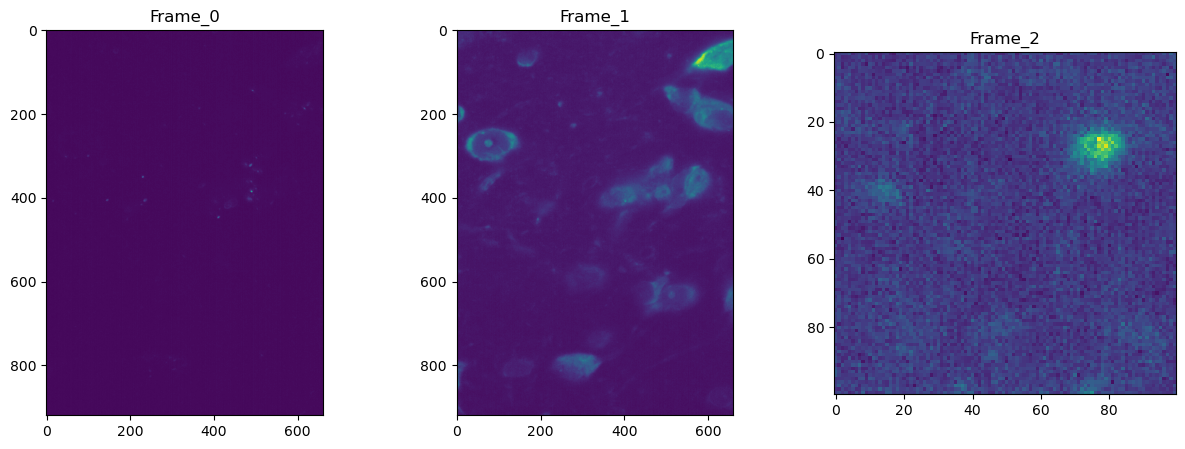

In [9]:
with pyczi.open_czi(f_r3v1) as czidoc:
    # define some plane coordinates
    plane_1 = {'C': 1, 'Z': 3, }

    roi = (200,200,100,100)
    
    # equivalent to reading {'C': 0, 'Z': 0, 'T': 0}
    frame_0 = czidoc.read()
    # get the shape of the 2d plane - the last dime indicates the pixel type
    print("Array Shape: ", frame_0.shape)

    # get specific planes 
    frame_1 = czidoc.read(plane=plane_1)
    
    frame_2 = czidoc.read(plane=plane_1, roi=roi)
    
    frame_3 = czidoc.read(plane=plane_1, scene=0) # what does this mean? not present
    
    frame_4 = czidoc.read(plane=plane_1, zoom=1)
    
print(
    frame_0.shape, frame_0.dtype,
    frame_1.shape, 
    frame_2.shape, 
    frame_3.shape, 
     )
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(frame_0[..., 0])
ax[0].set_title("Frame_0")
ax[1].imshow(frame_1[..., 0])
ax[1].set_title("Frame_1")
ax[2].imshow(frame_2[..., 0])
ax[2].set_title("Frame_2")

In [10]:
type(frame_2), frame_2.shape, frame_2.dtype

(numpy.ndarray, (100, 100, 1), dtype('uint16'))

In [11]:
data = skimage.data.kidney()
print(f'number of dimensions: {data.ndim}')
print(f'shape: {data.shape}')
print(f'dtype: {data.dtype}')

# create the filename for the new CZI image file
fout = os.path.join(outdir, "try1.czi")
numCH = 3
numZ = 16

# open a new CZI and allow overwrite (!!!) to play around ...
with pyczi.create_czi(fout, exist_ok=True) as fh:
    
    # loop over all z-planes and channels
    for z, ch in it.product(range(numZ), range(numCH)):
        
        # get the 2d array for the current plane
        array2d = data[z, ..., ch]

        # write the 2d plane with shape to the new CZI file
        fh.write(
            data=array2d,
            plane={"Z": z, "C": ch}
        )

number of dimensions: 4
shape: (16, 512, 512, 3)
dtype: uint16


100%|██████████| 48/48 [00:00<00:00, 1275.70it/s]


In [12]:
# import the "tiling strategy" from the cztile package
from cztile.fixed_total_area_strategy import AlmostEqualBorderFixedTotalAreaStrategy2D

# specify files 
f_src = f_r3v1 
f_dst = f_r3v1_out1

# create a "tile" 
tiler = AlmostEqualBorderFixedTotalAreaStrategy2D(
    total_tile_width=350,
    total_tile_height=500,
    min_border_width=10,
)

# create CZI instance to read some metadata 
with pyczi.open_czi(f_src) as czidoc_r:
    # get the size of the bounding rectange for the scence
    print(czidoc_r.total_bounding_box)
    print(czidoc_r.total_bounding_rectangle)
    print(czidoc_r.scenes_bounding_rectangle)
    tiles = tiler.tile_rectangle(czidoc_r.scenes_bounding_rectangle[0])

# show the created tile locations
for tile in tiles:
    print(tile.roi)

{'T': (0, 1), 'Z': (0, 151), 'C': (0, 2), 'R': (0, 1), 'I': (0, 1), 'H': (0, 1), 'V': (0, 1), 'X': (0, 660), 'Y': (0, 920)}
Rectangle(x=0, y=0, w=660, h=920)
{0: Rectangle(x=0, y=0, w=660, h=920)}
Rectangle(x=0, y=0, w=350, h=500)
Rectangle(x=0, y=420, w=350, h=500)
Rectangle(x=310, y=0, w=350, h=500)
Rectangle(x=310, y=420, w=350, h=500)


In [13]:
# open an existing CZI file for reading planes and a new CZI to insert
# the newly processed chunks into the new CZI file

# open a CZI instance to read and in parallel one to write
with (pyczi.open_czi(f_src) as czidoc_r, 
      pyczi.create_czi(f_dst, exist_ok=True) as czidoc_w):
        # loop over all tiles 
        for tile in tqdm(tiles):
            # read a specific tile from the CZI using the roi parameter
            tile2d = czidoc_r.read(
                plane={"C": 0},
                roi=(
                    tile.roi.x,
                    tile.roi.y,
                    tile.roi.w,
                    tile.roi.h
                )
            )

            # write the new CZI file using the processed data
            czidoc_w.write(
                tile2d,
                plane={"C": 0},
                location=(
                    tile.roi.x,
                    tile.roi.y
                )
            )

100%|██████████| 4/4 [00:00<00:00, 423.22it/s]
